In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA3%20mobilities%20eligible%20finalised%20started%20in%202014-2019.csv?inline=false')
reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA1%20mobilities%20eligible%20finalised%20started%20in%202018.csv?inline=false')
reply.encoding = 'utf-8'

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)
df.drop(columns=['GroupLeader', 'Sending Organisation Erasmus Code', 'Receiving Organisation Erasmus Code'], inplace=True)
c_df = df.copy() # we will use it for later (country network)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 GroupLeader
14 Participant Age
15 Sending Country Code
16 Sending City
17 Sending Organization
18 Sending Organisation Erasmus Code
19 Receiving Country Code
20 Receiving City
21 Receiving Organization
22 Receiving Organisation Erasmus Code
23 Participants


In [4]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690326,2018-2-UK01-KA125-048625,2018-2019,2018-09,2019-07,319.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
690327,2018-2-UK01-KA125-048626,2018-2019,2018-10,2019-03,137.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690328,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-04,170.0,Individual Volunteering Activities,? Unknown ?,CZ,??? - ? Unknown ?,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690329,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-10,351.0,Individual Volunteering Activities,? Unknown ?,FR,??? - ? Unknown ?,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [5]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 15, 18))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3789
4306


In [6]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df

Number of Receiving Universities:  3696
Number of Sending Universities:  4227


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending City,Receiving City
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...,FELDKIRCH,LUND
195,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...,LEOBEN,Saint-Petersburg
202,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
203,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
204,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
...,...,...,...,...,...,...
668733,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668734,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668735,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668736,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

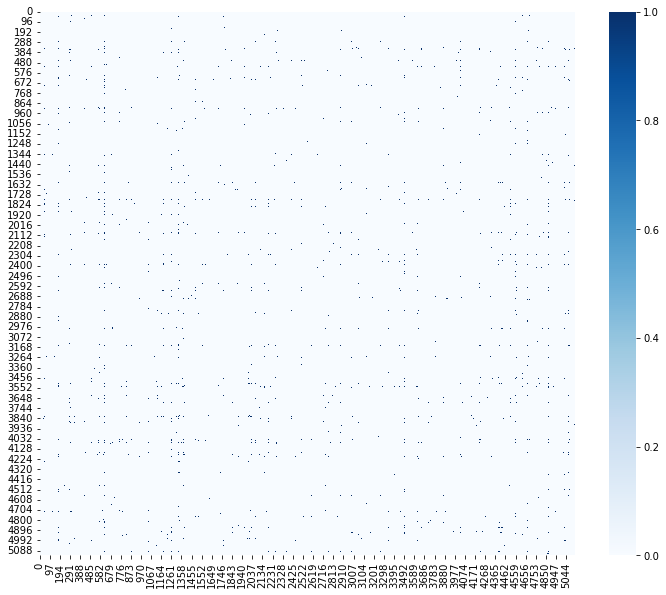

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
uni_cities = mobility_df.copy()
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

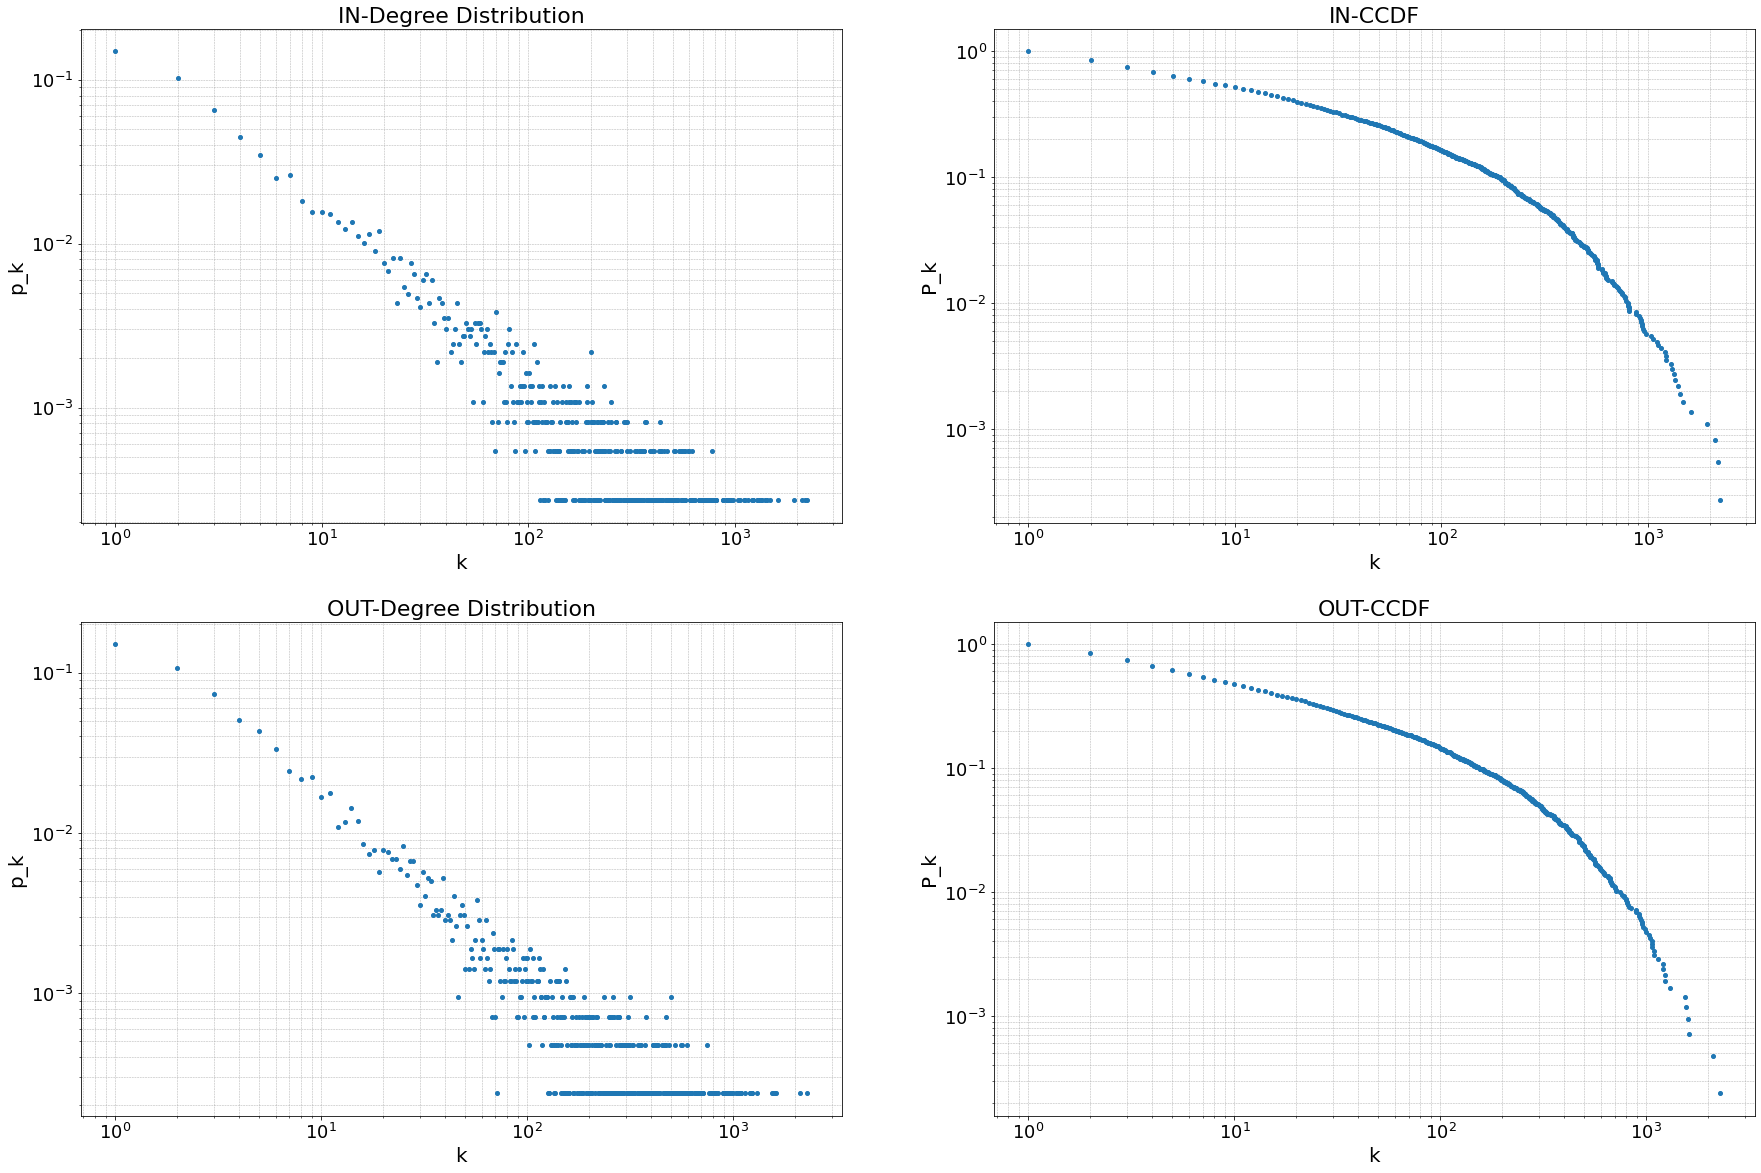

Top 10 for in degree


,Nodes,in degree
3814,UNIVERSITAT DE VALENCIA,2238
619,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2179
4460,UNIVERSIDADE DE LISBOA,2118
98,UNIVERSIDAD DE GRANADA,1931
913,UNIVERSIDAD COMPLUTENSE DE MADRID,1612
2333,UNIVERZA V LJUBLJANI,1481
180,UNIVERSITAT POLITECNICA DE VALENCIA,1434
3256,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1405
3477,UNIVERSIDAD DE SEVILLA,1350
4842,KATHOLIEKE UNIVERSITEIT LEUVEN,1341


Top 10 for out degree


,Nodes,out degree
619,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
98,UNIVERSIDAD DE GRANADA,2114
3814,UNIVERSITAT DE VALENCIA,1604
913,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
1962,UNIVERSITA DEGLI STUDI DI PADOVA,1563
3437,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
3421,UNIVERSITA DEGLI STUDI DI TORINO,1299
4460,UNIVERSIDADE DE LISBOA,1228
4842,KATHOLIEKE UNIVERSITEIT LEUVEN,1225
4772,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1203


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

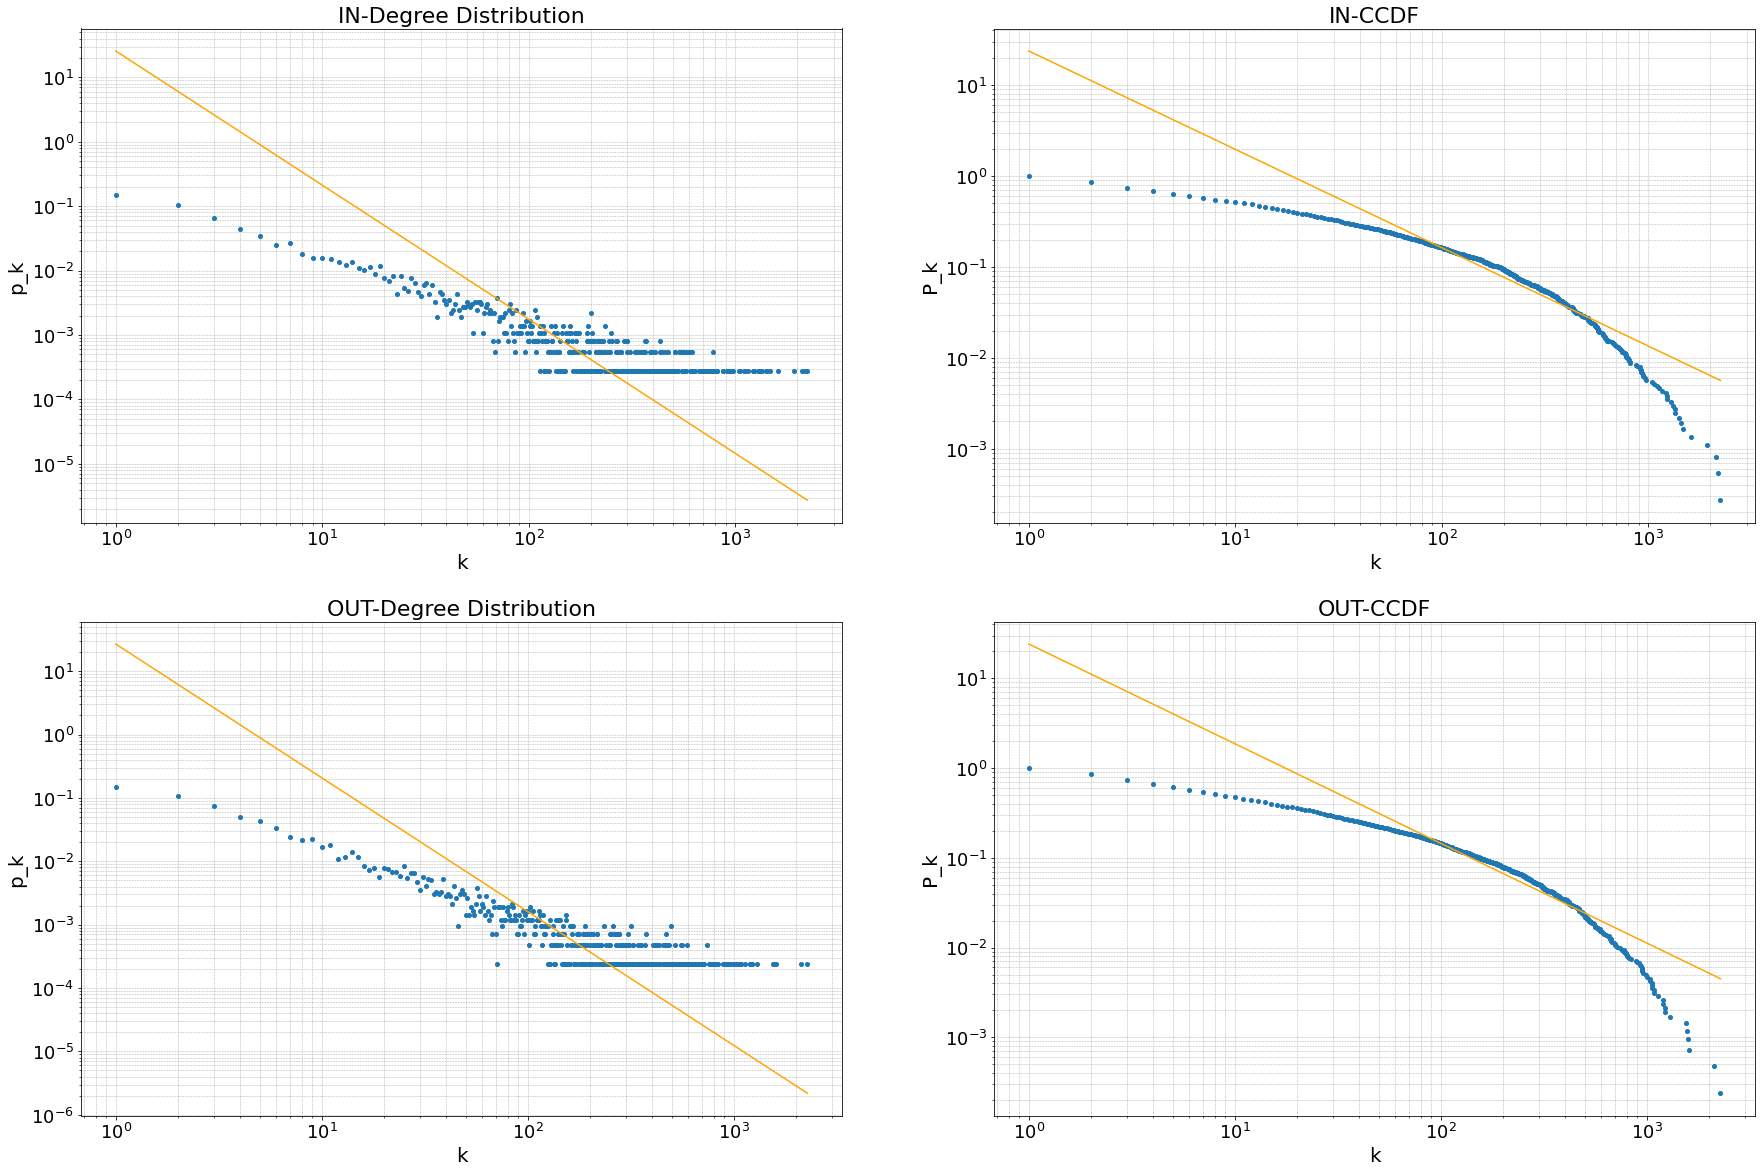

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

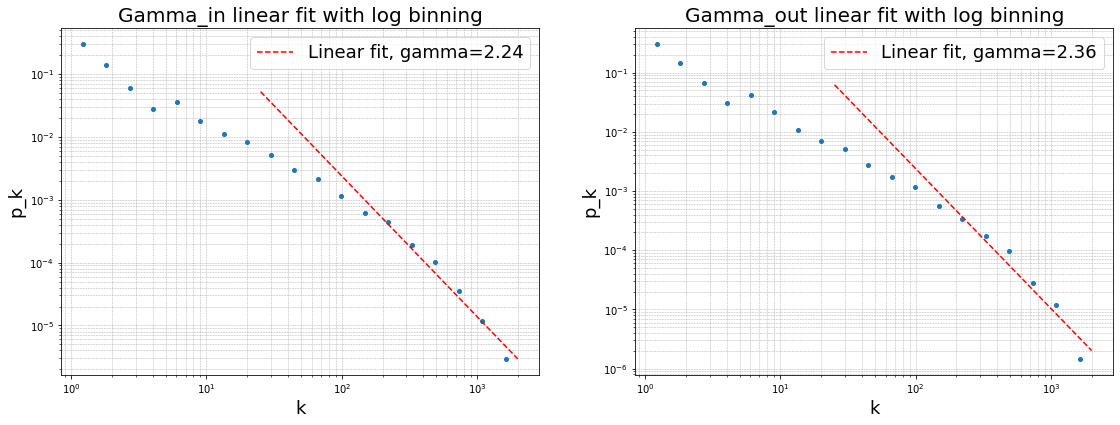

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

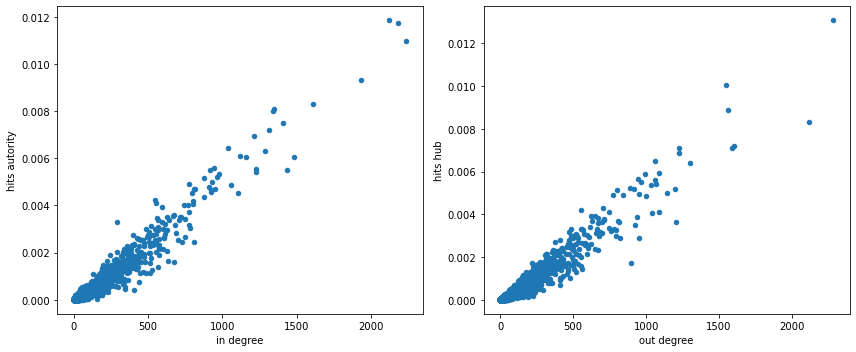

Top 10 for hits hub


,Nodes,hits hub
619,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013068
3437,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010048
1962,UNIVERSITA DEGLI STUDI DI PADOVA,0.008881
98,UNIVERSIDAD DE GRANADA,0.008339
3814,UNIVERSITAT DE VALENCIA,0.007203
4460,UNIVERSIDADE DE LISBOA,0.007114
913,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007107
4842,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006883
1608,TECHNISCHE UNIVERSITAET MUENCHEN,0.006487
3421,UNIVERSITA DEGLI STUDI DI TORINO,0.006378


Top 10 for hits autority


,Nodes,hits autority
4460,UNIVERSIDADE DE LISBOA,0.011846
619,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011721
3814,UNIVERSITAT DE VALENCIA,0.010979
98,UNIVERSIDAD DE GRANADA,0.009306
913,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008310
3477,UNIVERSIDAD DE SEVILLA,0.008109
4842,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008007
3256,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007508
1328,UNIVERZITA KARLOVA,0.007196
1278,UNIVERSITAT DE BARCELONA,0.006963


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

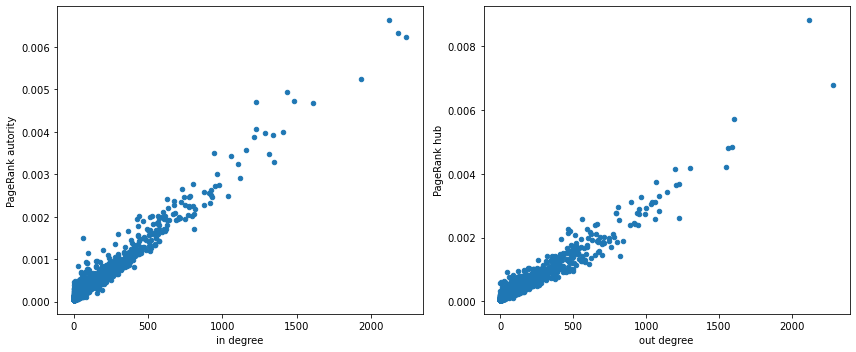

Top 10 for PageRank hub


,Nodes,PageRank hub
98,UNIVERSIDAD DE GRANADA,0.008810
619,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
3814,UNIVERSITAT DE VALENCIA,0.005716
913,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
1962,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
3437,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
3421,UNIVERSITA DEGLI STUDI DI TORINO,0.004182
1385,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
2333,UNIVERZA V LJUBLJANI,0.003745
4460,UNIVERSIDADE DE LISBOA,0.003693


Top 10 for PageRank autority


,Nodes,PageRank autority
4460,UNIVERSIDADE DE LISBOA,0.006626
619,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006335
3814,UNIVERSITAT DE VALENCIA,0.006226
98,UNIVERSIDAD DE GRANADA,0.005244
180,UNIVERSITAT POLITECNICA DE VALENCIA,0.004949
2333,UNIVERZA V LJUBLJANI,0.004723
1631,POLITECNICO DI MILANO,0.004714
913,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004670
1962,UNIVERSITA DEGLI STUDI DI PADOVA,0.004074
3256,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.003990


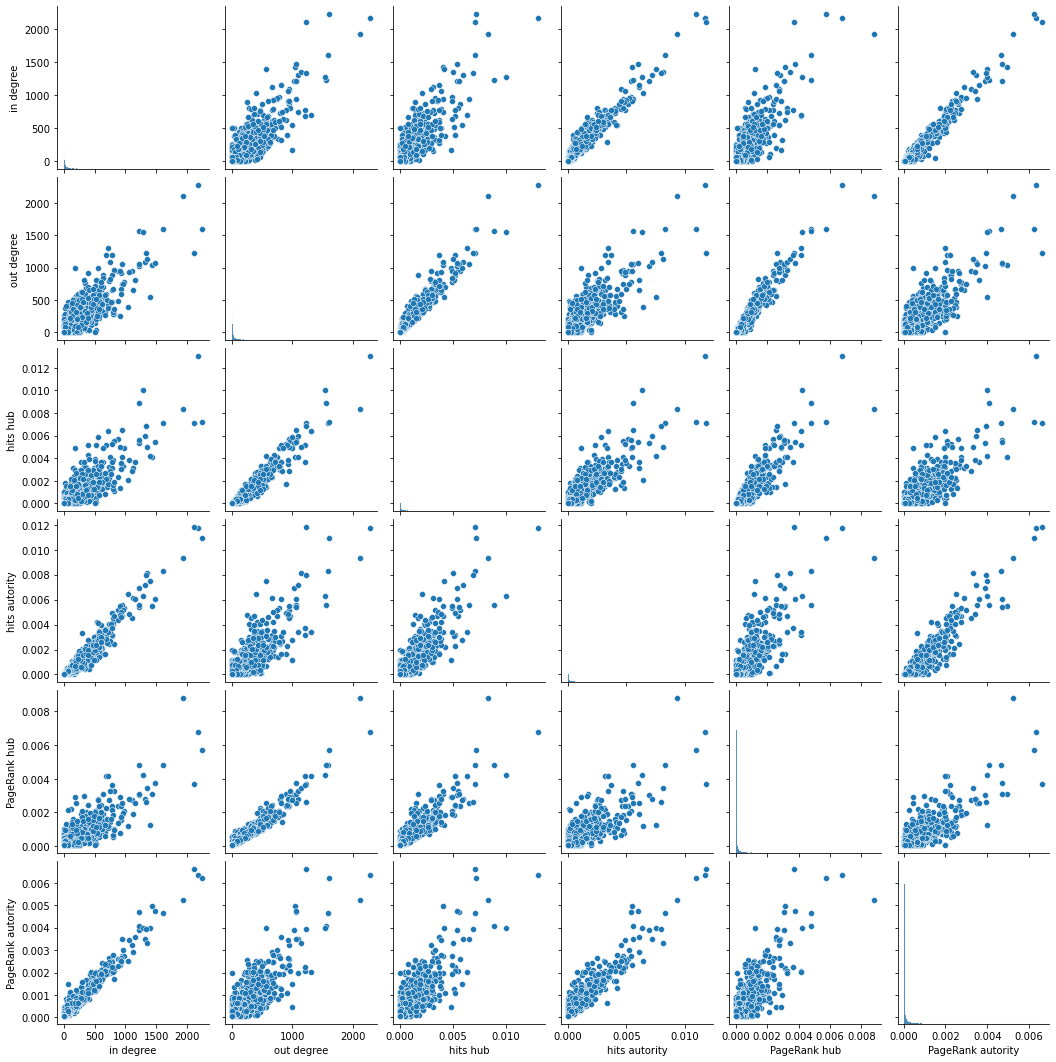

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

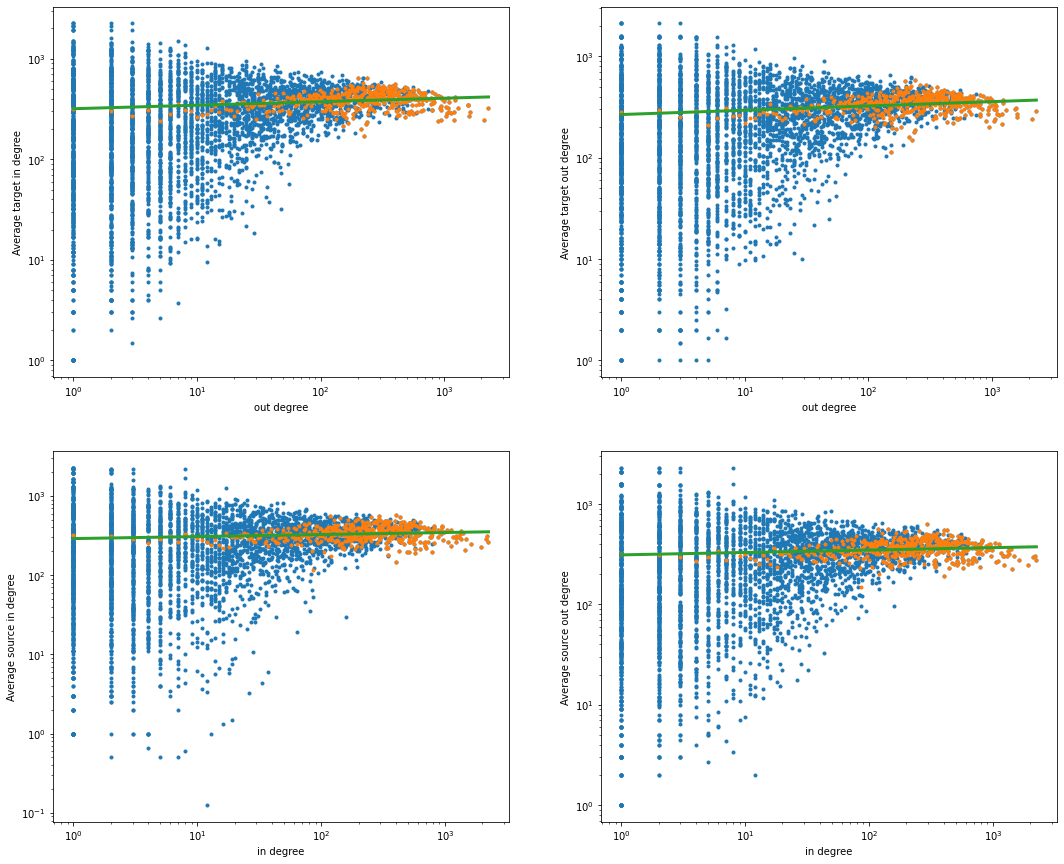

(0.034832263162413606,
 0.042430769518188936,
 0.02551010144932137,
 0.02403733513504581)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

## Communities

In [20]:
import networkx as nx

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['uni_Community'] = node_comm['Community']
# 52 communities. Choose if it makes sense to reduce the number of them 

,Nodes,Community
1,STICHTING ARTEZ,0
3,UNIVERSIDAD DE QUINTANA ROO,0
4,UNIVERSITY OF LINCOLN,0
8,GEDIK UNIVERSITY,0
9,BANDIRMA ONYEDI EYLUL UNIVERSITY,0
...,...,...
5090,JAVNA USTANOVA UNIVERZITET CRNE GORE PODGORICA,0
5091,ECOLE NATIONALE SUPÉRIEURE DE CRÉATION INDUSTR...,0
5093,ROYAL THIMPHU COLLEGE,0
5094,ASSOCIATION POUR LA GESTION DE L'ECOLE SUPERIE...,0


,Nodes,Community
2,NANKAI UNIVERSITY,1
5,FACULTAD DE CIENCIAS ECONÓMICAS - UNIVERSIDAD ...,1
7,ECOLE NATIONALE DES TRAVAUX PUBLICS DE L'ETAT,1
10,"UNIVERSITY OF MANOUBA, FACULTY OF LETTERS, ART...",1
12,KAROLI GASPAR REFORMATUS EGYETEM,1
...,...,...
5081,HOCHSCHULE FÜR ANGEWANDTES MANAGEMENT GMBH,1
5083,MALMOE HOEGSKOLA (MALMOE UNIVERSITY),1
5085,TECHNISCHE UNIVERSITAT HAMBURG,1
5086,NATIONAL UNIVERSITY OF SINGAPORE,1


,Nodes,Community
0,UNIVERSITATEA TEHNICA GHEORGHE ASACHI DIN IASI,2
6,UNIVERSITY OF PATRAS,2
11,UNIVERSIDAD DE BURGOS,2
22,UNIVERSIDADE ZAMBEZE,2
24,ISA YNCRÉA HAUTS DE FRANCE,2
...,...,...
5061,ALEXANDRIA UNIVERSITY,2
5067,OSTRAVSKA UNIVERZITA V OSTRAVE,2
5073,BOGOR AGRICULTURAL UNIVERSITY (IPB),2
5092,"NATIONAL UNIVERSITY ""OSTROH ACADEMY""",2


,Nodes,Community
66,FORSVARSHOGSKOLAN,3
144,KATHOLISCHE HOCHSCHULE MAINZ,3
154,THEOLOGISCHE FAKULTAET PADERBORN,3
272,WYZSZA SZKOLA ADMINISTRACJI I BIZNESU IM. E. K...,3
464,POLIS AKADEMISI,3
...,...,...
4914,ECOLES DE SAINT-CYR COETQUIDAN,3
4923,"ACADEMIA FORTELOR TERESTRE ""NICOLAE BALCESCU""",3
4953,NEMZETI KOZSZOLGALATI EGYETEM,3
4989,PANSTWOWA MEDYCZNA WYZSZA SZKOLA ZAWODOWA W OPOLU,3


,Nodes,Community
338,NATSIONALNA SPORTNA AKADEMIYA VASSIL LEVSKI,4
466,NOVOSIBIRSK STATE UNIVERSITY,4
548,LATVIJAS SPORTA PEDAGOGIJAS AKADEMIJAS,4
549,AMERICAN UNIVERSITY OF CENTRAL ASIA INSTITUTION,4
989,MEDITCINSKY UNIVERSITET-PLOVDIV,4
...,...,...
4148,SLIPPERY ROCK UNIVERSITY OF PENNSYLVANIA,4
4276,STATE EDUCATIONAL INSTITUTION OF HIGHER PROFES...,4
4669,DEUTSCHE SPORTHOCHSCHULE KOLN,4
4740,DIMOKRITIO PANEPISTIMIO THRAKIS,4


,Nodes,Community
478,FACULTY OF ECONOMICS UNIVERSITY OF KRAGUJEVAC,5
803,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,5
1032,CAPE PENINSULA UNIVERSITY OF TECHNOLOGY,5
1204,I-SHOU UNIVERSITY,5
1314,THE QUEEN&APOS;S UNIVERSITY OF BELFAST,5
...,...,...
4579,FINANSOVIY UNIVERSITET PRI PRAVITELSTVE ROSSIY...,5
4800,SHOTA RUSTAVELI STATE UNIVERSITY,5
4823,FOREIGN TRADE UNIVERSITY,5
5050,UNIVERSITY OF DONJA GORICA,5


,Nodes,Community
569,SOKHUMI STATE UNIVERSITY,6
1175,HOCHSCHULE FULDA,6
2466,NATIONAL AVIATION UNIVERSITY,6
2502,NAMANGAN STATE UNIVERSITY,6
2825,ECOLE POLYTECHNIQUE PRIVÉE D'AGADIR,6
...,...,...
3829,AZERBAIJAN STATE ECONOMIC UNIVERSITY LLC,6
3922,DATA LINK INSTITUTE,6
4515,HIGHER INSTITUTE OF TECHNOLOGICAL STUDIES OF ...,6
4595,TURGUT OZAL EDUCATION SHA,6


,Nodes,Community
235,ILISIMATUSARFIK,7
546,MOSCOW STATE INSTITUTE OF INTERNATIONAL RELATI...,7
763,PÄDAGOGISCHE HOCHSCHULE SALZBURG,7
1207,CHINA FOREIGN AFFAIRS UNIVERSITY,7
1437,BALTIC STATE TECHNICAL UNIVERSITY VOENMEKH NAM...,7
...,...,...
3860,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,7
4012,CHINA UNIVERSITY OF POLITICAL SCIENCE AND LAW,7
4464,NORD UNIVERSITET,7
4703,YURIY FEDKOVYCH CHERNIVTSI NATIONAL UNIVERSITY,7


,Nodes,Community
676,NATIONAL UNIVERSITY OF MANAGEMENT,8
1538,EVANGELISCHE THEOLOGISCHE FACULTEIT,8
1747,ISTANBUL SISLI MESLEK YUKSEKOKULU,8
1940,VIESOJI ISTAIGA KOLPINGO KOLEGIJA,8
2258,HIGHER EDUCATIONAL ESTABLISHMENT UKRAINIAN CAT...,8
...,...,...
3813,LATVIJAS KRISTIGA AKADEMIJA,8
4053,LCC INTERNATIONAL UNIVERSITY,8
4491,CAUCASUS UNIVERSITY LTD,8
4739,PROTESTANTSE THEOLOGISCHE UNIVERSITEIT,8


,Nodes,Community
674,NATIONAL MINING UNIVERSITY,9
2201,CHINA UNIVERSITY OF MINING AND TECHNOLOGY (BEI...,9
2541,AMIRKABIR UNIVERSITY OF TECHNOLOGY,9
2887,DMT - GESELLSCHAFT FÜR LEHRE UND BILDUNG MBH -...,9
3297,"UNIVERSITI TEKNOLOGI MARA, SHAH ALAM",9
...,...,...
3566,MONTANUNIVERSITAT LEOBEN,9
3659,FEDERAL STATE BUDGETARY EDUCATIONALINSTITUTION...,9
4211,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,9
4310,BELGOROD STATE TECHNOLOGICAL UNIVERSITY NAMED ...,9


,Nodes,Community
130,SÁROSPATAKI REFORMÁTUS TEOLÓGIAI AKADÉMIA,10
787,THEOLOGISCHE UNIVERSITEIT VAN DE GEREFORMEERDE...,10
1163,AUGUSTANA-HOCHSCHULE,10
1320,PROTESTANT THEOLOGICAL INSTITUTE OF CLUJ-NAPOCA,10
2351,DET TEOLOGISKE MENIGHETSFAKULTET,10
3312,EVANGÉLIKUS HITTUDOMÁNYI EGYETEM,10
3742,DEBRECENI REFORMÁTUS HITTUDOMÁNYI EGYETEM,10
4394,FULLER THEOLOGICAL SEMINARY,10


,Nodes,Community
131,MEIJI UNIVERSITY EDUCATIONAL FOUNDATION,11
171,NATIONAL UNIVERSITY CORPORATION KYUSHU UNIVERSITY,11
1966,CHIBA DAIGAKU,11
2300,UNIVERSIDAD CENTRAL DE VENEZUELA,11
2369,ECOLE POLYTECHNIQUE D'ARCHITECTURE ET D'URBANISME,11
4367,ECOLE NATIONALE SUPERIEURE D'ARCHITECTURE DE P...,11
4435,UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL,11
4493,UNIVERSITY OF TOKYO,11


,Nodes,Community
1875,CONSERVATORIO SUPERIOR DE DANZA DE ALICANTE,12
1927,FIRST RAMALLAH GROUP ASSOCIATION,12
2216,ACCADEMIA NAZIONALE DI DANZA,12
2482,MAGYAR TANCMUVESZETI EGYETEM,12
2953,CONSERVATORIO SUPERIOR DE DANZA DE VALENCIA,12
4931,PALESTINIAN CIRCUS,12
4933,DONKO SEKO,12


,Nodes,Community
691,HIGHER HOTEL INSTITUTE CYPRUS (HHIC),13
1372,IES HOTEL ESCUELA,13
2368,LYCÉE DES MÉTIERS DE L'HÔTELLERIE ET DU TOURIS...,13
2776,SOUTH WEST COLLEGE,13
4107,CENTRO INTEGRAL DE FP ILERNA S.L.,13
4200,IES MARIA DE ZAYAS Y SOTOMAYOR,13
5057,CENTRE INTEGRAL DE FP ILERNA S.L.,13


,Nodes,Community
1409,ISTANBUL SABAHATTIN ZAIM UNIVERSITY,14
2452,ISLAMIC UNIVERSITY OF APPLIED SCIENCES ROTTERDAM,14
2660,FACHHOCHSCHULE COBURG,14
3799,INTERNATIONAL CENTRE FOR EDUCATION IN ISLAMIC ...,14
4938,UNIVERSITE EZ-ZITOUNA,14
4965,UNIVERSITE ALQUARAOUIYINE,14


,Nodes,Community
393,LYCÉE JULES GUESDE,15
1286,I.E.S. FERMIN BOUZA BREY,15
2477,INSTITUT DE VIC,15
2573,INSTITUT ESCOLA DEL TREBALL,15
3464,LYCEE GENERAL TECHNIQUE GASTON BERGER,15
5009,FONDAZIONE ISTITUTO TECNICO SUPERIORE PER LE N...,15


,Nodes,Community
163,CONSERVATORIO STATALE DI MUSICA A.STEFFANI,16
2211,UNIVERSIDAD NACIONAL DE GENERAL SAN MARTIN,16
2637,CONSERVATORIO SUPERIOR DE MÚSICA DE CASTILLA-L...,16
2868,INSTITUTIA PUBLICA ACADEMIA DE MUZICA TEATRU S...,16
4984,SONCA INTERNATIONAL/MUSIARTE,16
5036,"CONSERVATORIO DI MUSICA DI STATO ""ANTONIO SCON...",16


,Nodes,Community
257,UNIVERZA V NOVI GORICI,17
747,AZERBAIJAN STATE AGRICULTURE UNIVERSITY,17
1149,NORTH-CAUCASUS FEDERAL UNIVERSITY,17
1860,O.M. BEKETOV NATIONAL UNIVERSITY OF URBAN ECON...,17
2350,MINGACHEVIR STATE UNIVERSITY,17


,Nodes,Community
270,UNIVERSIDAD FINIS TERRAE,18
1217,DALIAN NATIONALITIES UNIVERSITY,18
1376,TAYLOR'S UNIVERSITY MALAYSIA,18
1612,SAINT PETERSBURG ELECTROTECHNICAL UNIVERSITY LETI,18
4203,ERHVERVSAKADEMI SJÆLLAND,18


,Nodes,Community
713,SPRACHEN- UND DOLMETSCHER-INSTITUTMUNCHEN EV,19
3620,STATE EDUCATION INSTITUTION OF HIGHER PROFESSI...,19
3820,MOSCOW REGION STATE UNIVERSITY,19
4152,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,19
4586,QINGDAO UNIVERSITY,19


,Nodes,Community
1466,INSTITUTO POLITÉCNICO DE GESTÃO E TECNOLOGIA -...,20
3069,PANSTWOWA SZKOLA WYZSZA IM PAPIEZA JANA PAWLA ...,20
3383,UNIVERZITET ZA TURIZAM I MENAGMENT VO SKOPJE,20
3958,SIHE I. HORBACHEVSKY TERNOPIL STATE MEDICAL UN...,20
4826,BREST STATE UNIVERSITY NAMED AFTER A.S. PUSHKI...,20


,Nodes,Community
1185,ZHEJIANG CHINESE MEDICAL UNIVERSITY,21
1768,GGTU,21
2584,UNIVERSITATEA DE VEST VASILE GOLDIS DIN ARAD,21
2889,ZHEJIANG UNIVERSITY OF SCIENCE AND TECHNOLOGY,21


,Nodes,Community
1226,ASSOCIATION RÉGIONALE POUR LA FORMATION PLURIP...,22
1541,HAUTE ECOLE EN HAINAUT,22
3562,ARFIS OI,22
4283,GROUPE 3IL,22


,Nodes,Community
329,DIMITRIE CANTEMIR UNIVERSITY OF TARGU MURES,23
814,PANNASASTRA UNIVERSITY OF CAMBODIA,23
2494,ADNAN MENDERES UNIVERSITESI,23
5074,CHEN XINGRONG,23


,Nodes,Community
1398,NATIONAL UNIVERSITY OF CVIL ENGINEERING,24
1439,FRENCH-VIETNAMESE CENTER FOR MANAGEMENT EDUCATION,24
1923,ECOLE NATIONALE SUPERIEURE DES MINES D'ALES,24


,Nodes,Community
1041,VIESOJI ISTAIGA SOCIALINIU MOKSLU KOLEGIJA,25
1080,HANNAM UNIVERSITY,25
2249,UNIVERSITETI AAB,25


,Nodes,Community
142,PÔLE SUPÉRIEUR D'ENSEIGNEMENT ARTISTIQUE PARIS...,26
1540,ANTON BRUCKNERPRIVATUNIVERSITAT,26
3444,NORGES DANSEHØYSKOLE,26


,Nodes,Community
1798,PANSTWOWA WYZSZA SZKOLA ZAWODOWA W CHELMIE,27
1821,VYSOKA SKOLA MEDZINARODNEHO PODNIKANIA ISM SLO...,27
3792,VYSOKA SKOLA EKONOMIE A MANAGEMENTU OPS,27


,Nodes,Community
2622,ANOTATI ECCLESIASTIKI AKADEMIA THESSALONIKIS,28
3650,RELIGIOUS ORGANIZATION OF HIGHER THEOLOGICAL E...,28
3842,KYIV THEOLOGICAL ACADEMY AND SEMINARY OF UKRAI...,28


,Nodes,Community
88,NORTHERN MICHIGAN UNIVERSITY,29
2546,SHANGHAI JIAN QIAO UNIVERSITY,29
3917,UNIVERSITATEA DE ARTA SI DESIGN DINCLUJ-NAPOCA,29


,Nodes,Community
1920,"VISOKA SKOLA ""CEPS - CENTAR ZA POSLOVNE STUDIJ...",30
1929,MARIN BARLETI SHA,30
3940,IES RIBEIRA DO LOURO,30


,Nodes,Community
869,KEMEROVO STATE UNIVERSITY OF CULTURE,31
3308,THE JERUSALEM ACADEMY OF MUSIC AND DANCE,31
4016,BUDAPEST KORTARSTANC FOISKOLA,31


,Nodes,Community
71,MEGATREND UNIVERZITET,32
1656,UMAN NATIONAL UNIVERSITY OF HORTICULTURE,32
4430,MAZOWIECKA UCZELNIA PUBLICZNA W PLOCKU,32


,Nodes,Community
410,HOGSKOLEN I HEDMARK,33
732,BISHOP GROSSETESTE UNIVERSITY COLLEGE LINCOLN,33


,Nodes,Community
729,PAVLO TYCHYNA UMAN STATE PEDAGOGICAL UNIVERSITY,34
2056,PANSTWOWA WYZSZA SZKOLA ZAWODOWA IM. HIPOLITA ...,34


,Nodes,Community
2207,PADAGOGISCHE HOCHSCHULE OBEROSTERREICH,35
2695,BELARUSKI DZIARZHAUNY PEDAGOGICHNYUNIVERSITET ...,35


,Nodes,Community
1992,"FACULTY OF EDUCATION, UNIVERSITY OF KRAGUJEVAC",36
2844,EOTVOS JOZSEF FOISKOLA,36


,Nodes,Community
2791,ESCOLA SUPERIOR DE EDUCAÇÃO DE FAFE,37
2992,AMASYA UNIVERSITESI,37


,Nodes,Community
853,ADDIS ABABA UNIVERSITY,38
3501,SCUOLA SUPERIORE DI STUDI UNIVERSITARI E DI PE...,38


,Nodes,Community
3108,UNIVERSIDAD GALILEO,39
3526,TÉLÉCOM SUDPARIS,39


,Nodes,Community
2229,LYCEE DE L'HOTELLERIE ET DU TOURISME GEORGES F...,40
3722,SSML GREGORIO VII,40


,Nodes,Community
3910,COLLEGE OF APPLIED SCIENCES LAVOSLAV RUZICKA I...,41
4021,"SVEUČILIŠTE/UNIVERZITET ""VITEZ"" VITEZ",41


,Nodes,Community
1632,LYCEE AMPERE,42
4284,INSTITUT POBLENOU,42


,Nodes,Community
1946,STIFTUNG PRIVATE PÄDAGOGISCHE HOCHSCHULE BURGE...,43
4640,PROFESSIONHOJSKOLEN I REGION SJAELLAND,43


,Nodes,Community
83,ESCA ECOLE DE MANAGEMENT,44
4657,RIGAS STARPTAUTISKA EKONOMIKAS UN BIZNESA ADMI...,44


,Nodes,Community
4115,GEORGIAN INSTITUTE OF PUBLIC AFFAIR FOUNDATION,45
4675,NLA HØGSKOLEN,45


,Nodes,Community
2048,FREE UNIVERSITY OF TBILISI,46
4681,AUTOGRAF,46


,Nodes,Community
210,KOREA NATIONAL UNIVERSITY OF ARTS,47
4688,HOCHSCHULE OSTWESTFALEN-LIPPE,47


,Nodes,Community
3514,CONSERVATOIRE NATIONAL SUPÉRIEUR D'ART DRAMATIQUE,48
4943,HOCHSCHULE FÜR SCHAUSPIELKUNST ERNST BUSCH,48


,Nodes,Community
802,"VISOKA MEDICINSKA SKOLA STRUKOVNIH STUDIJA ""MI...",49
5040,VELEUCILISTE U BJELOVARU,49


,Nodes,Community
2781,FUNDACION UNIVERSIDAD DE LAS AMERICAS PUEBLA,50


## Geographical heatmap

In [21]:
temp_df = uni_cities[['target', 'Receiving City']].copy()
temp_df.rename({'target':'source', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['source', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)

for index in range(cities_uni.shape[0]):
    city = cities_uni.iat[index,1]
    if city != city.upper():
        cities_uni.iat[index,1] = city.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['source'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City
0,UNIVERSITATEA TEHNICA GHEORGHE ASACHI DIN IASI,0,91,48,0,1.663239e-04,4.145752e-04,0,0.000263,0.000286,2,IASI
1,STICHTING ARTEZ,1,43,21,1,6.087821e-06,4.367450e-05,1,0.000119,0.000305,0,ARNHEM
2,NANKAI UNIVERSITY,2,0,1,2,6.548252e-06,-0.000000e+00,2,0.000047,0.000043,1,TIANJIN
3,UNIVERSIDAD DE QUINTANA ROO,3,0,1,3,5.928947e-06,-0.000000e+00,3,0.000048,0.000043,0,"CHETUMAL, QUINTANA ROO"
4,UNIVERSITY OF LINCOLN,4,77,28,4,1.009149e-04,3.211130e-04,4,0.000113,0.000265,0,LINCOLN
...,...,...,...,...,...,...,...,...,...,...,...,...
5094,ASSOCIATION POUR LA GESTION DE L'ECOLE SUPERIE...,5094,2,7,5094,3.547434e-06,4.852543e-06,5094,0.000060,0.000048,0,BELFORT
5095,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,5095,0,12,5095,9.936067e-07,-0.000000e+00,5095,0.000118,0.000043,0,LECCE
5096,LIBERA UNIVERSITA MARIA SS ASSUNTA,5096,72,0,5096,-0.000000e+00,2.428668e-04,5096,0.000045,0.000276,1,ROMA
5097,ROSTOVSKIJ GOSUDARSTVENNYJ EKONOMICHESKIJ UNIV...,5097,0,2,5097,7.117674e-09,-0.000000e+00,5097,0.000060,0.000043,5,ROSTOV-ON-DON


In [22]:
city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino, Madrid (these are also pretty much important)

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City,city,city_ascii,lat,lng,iso2,admin_name
0,STICHTING ARTEZ,1,43,21,1,6.087821e-06,4.367450e-05,1,0.000119,0.000305,0,ARNHEM,ARNHEM,Arnhem,51.9833,5.9167,NL,Gelderland
1,NANKAI UNIVERSITY,2,0,1,2,6.548252e-06,-0.000000e+00,2,0.000047,0.000043,1,TIANJIN,TIANJIN,Tianjin,39.1467,117.2056,CN,Tianjin
2,UNIVERSITY OF LINCOLN,4,77,28,4,1.009149e-04,3.211130e-04,4,0.000113,0.000265,0,LINCOLN,LINCOLN,Lincoln,40.8090,-96.6788,US,Nebraska
3,GEDIK UNIVERSITY,8,0,14,8,8.323200e-06,-0.000000e+00,8,0.000079,0.000043,0,ISTANBUL,ISTANBUL,Istanbul,41.0100,28.9603,TR,İstanbul
4,"UNIVERSITY OF MANOUBA, FACULTY OF LETTERS, ART...",10,0,1,10,2.182861e-06,-0.000000e+00,10,0.000047,0.000043,1,TUNIS,TUNIS,Tunis,36.8008,10.1800,TN,Tunis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,ROYAL THIMPHU COLLEGE,5093,1,2,5093,2.300891e-06,3.703804e-07,5093,0.000048,0.000055,0,THIMPHU,THIMPHU,Thimphu,27.4833,89.6333,BT,Thimphu
3520,ASSOCIATION POUR LA GESTION DE L'ECOLE SUPERIE...,5094,2,7,5094,3.547434e-06,4.852543e-06,5094,0.000060,0.000048,0,BELFORT,BELFORT,Belfort,47.6400,6.8500,FR,Bourgogne-Franche-Comté
3521,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,5095,0,12,5095,9.936067e-07,-0.000000e+00,5095,0.000118,0.000043,0,LECCE,LECCE,Lecce,40.3520,18.1691,IT,Puglia
3522,LIBERA UNIVERSITA MARIA SS ASSUNTA,5096,72,0,5096,-0.000000e+00,2.428668e-04,5096,0.000045,0.000276,1,ROMA,ROMA,Roma,26.4166,-99.0060,US,Texas


Importing geographic data also for countries

In [23]:
import geopandas as gpd
import pycountry as pc #library used for translating country codes from iso3 to iso2 standard

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# merge geometries with our dataframe
geo_scores = pd.merge(left=scores_cities, right=geo_df[['iso2_code', 'geometry']], how='left', 
                      left_on='iso2', right_on='iso2_code')
geo_scores = geo_scores[['Nodes', 'PageRank hub', 'PageRank autority', 'City', 'lat', 'lng',
                         'iso2', 'geometry', 'uni_Community']]

Dividing universities by their country community

In [24]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
c_nodes = np.array(list(pd.concat([country_df.loc[:, country_df.columns[0]], country_df.loc[:, country_df.columns[1]]]).drop_duplicates()))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

,Nodes,Community
1,AT,0
4,KR,0
9,CA,0
16,US,0
17,UG,0
...,...,...
125,IR,0
133,BW,0
137,BT,0
143,VE,0


,Nodes,Community
2,UA,1
3,RU,1
5,RS,1
7,IL,1
8,PS,1
...,...,...
120,AF,1
122,SD,1
126,RW,1
134,LY,1


,Nodes,Community
6,ET,2
11,AU,2
12,NZ,2
21,NP,2
30,UZ,2
...,...,...
136,AO,2
138,IQ,2
139,MR,2
141,SR,2


,Nodes,Community
0,PT,3
23,IN,3
26,TN,3
34,JO,3
58,TZ,3
...,...,...
112,NO,3
115,TL,3
116,LA,3
117,SE,3


,Nodes,Community
24,BE,4
61,CM,4
104,LI,4
127,CD,4
128,NI,4
146,CH,4


Focus on european countries

In [25]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]

(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

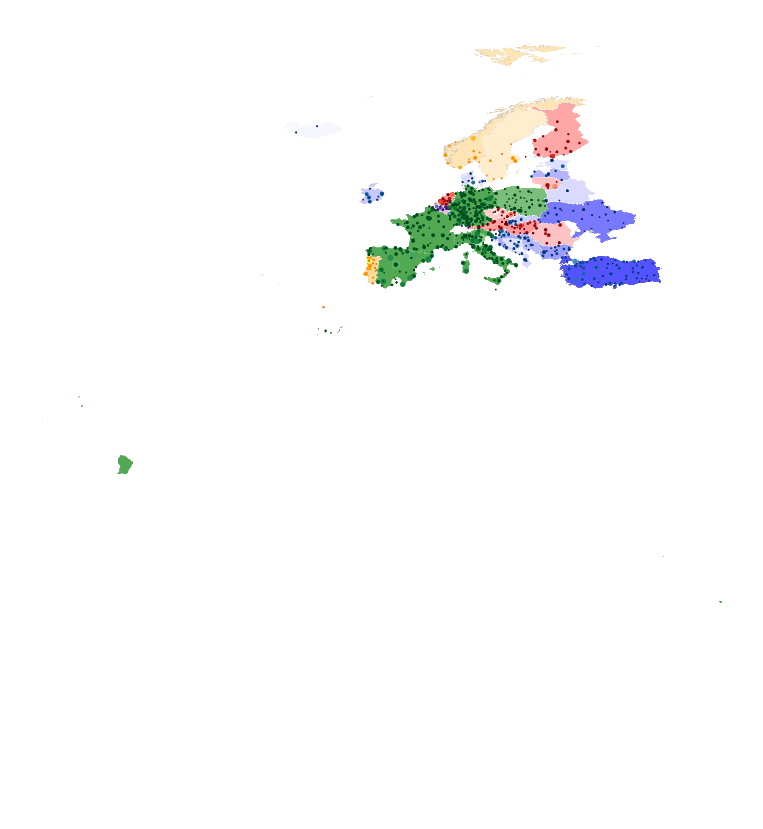

In [26]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Wistia_r', 'Purples_r']

fig, ax = plt.subplots(figsize=(20,15))

for c in range(5):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
ax.axis('off')

### Universities communities geographic plot

(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

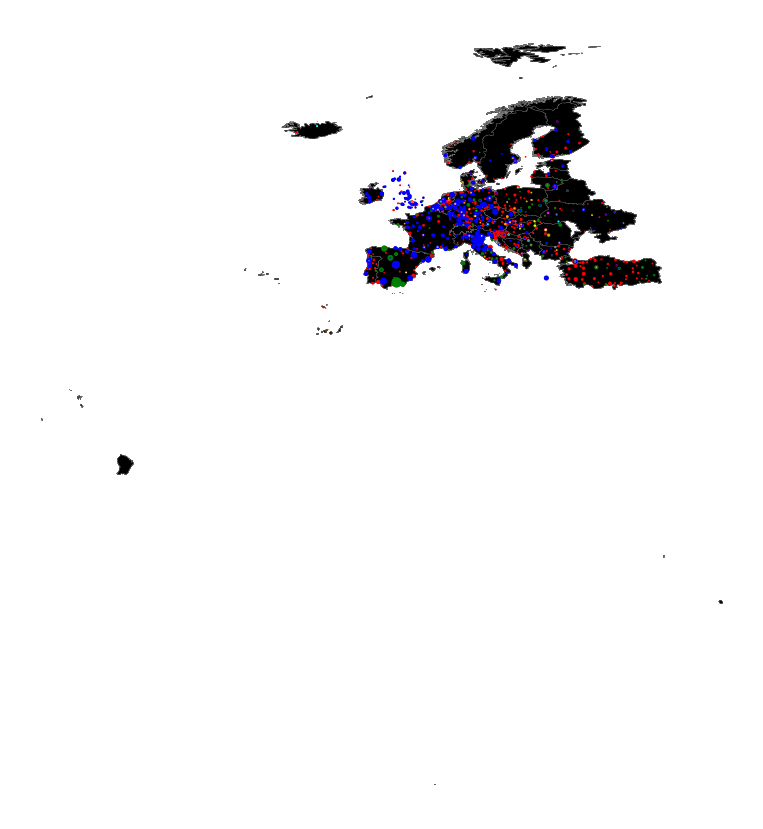

In [32]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey', 'gold', 'aqua', 'fuchsia', 'pink', 'yellow', 'salmon', 
          'khaki', 'brown', 'lime', 'skyblue', 'peachpuff', 'ivory', 'powderblue', 'rosybrown', 'royalblue', 
          'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue',
          'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet',
          'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 
          'lightseagreen', 'lightskyblue', 'lightslategray']

geo_plt = geo_scores.copy()
# dropping all communities containing number of universities lower or equal than 3
for c in range(max(geo_plt['uni_Community'])):
    if geo_plt[geo_plt['uni_Community'] == c].shape[0] <= 2:
        geo_plt = geo_plt[geo_plt['uni_Community'] != c]

fig, ax = plt.subplots(figsize=(20,15))

geo_plt = gpd.GeoDataFrame(geo_plt, geometry='geometry')
geo_plt.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color='0')

# sns.scatterplot(x='lng', y='lat', data=geo_plt, hue='uni_Community', legend=False, ax=ax, size=geo_plt['PageRank hub']*10**4)
# ax.scatter(x=geo_plt['lng'], y=geo_plt['lat'], s=geo_plt['PageRank hub']*10**4, c=geo_plt['uni_Community'], cmap='jet')

for c in list(geo_plt['uni_Community'].unique()):
    temp_df = geo_plt[geo_plt['uni_Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'], cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'])
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, color=colors[c])
ax.axis('off')

### Robustness

In [ ]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [ ]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()